In [64]:
import os
from os.path import dirname, basename
from tifffile import imread
from shapely.geometry import Point, Polygon
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

In [65]:
folder_data = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT/selected_condensates_best"
os.chdir(folder_data)
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_coralled by nano domains/FUS488_FL_PAINT"

all_files = os.listdir(".")
lst_fname_left_csv = [f for f in all_files if f.endswith("left.csv")]
lst_fname_left_PAINT = [
    f.split("left.csv")[0] + "left-PAINT.tif" for f in lst_fname_left_csv
]
lst_fname_right_csv = [f.split("left.csv")[0] + "right.csv" for f in lst_fname_left_csv]
lst_fname_right_PAINT = [
    f.split("left.csv")[0] + "right-PAINT.tif" for f in lst_fname_left_csv
]
# Parameters
nm_per_pxl = 117  # ONI scale
r_max_nm = 1000
ringwidth_nm = 200
dr_slidingrings_nm = 50  # stepsize between adjascent overlaping rings, nm
bins = np.arange(
    0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
)  # overlaping bins (sliding window)
# round UP for boundary correction, see function PairCorrelation_perCell()
r_max_pxl = math.ceil(r_max_nm / 117)

In [66]:
def cnt2mask(imgshape, contours):
    # create empty image
    mask = np.zeros(imgshape, dtype=np.uint8)
    # draw contour
    for cnt in contours:
        cv2.fillPoly(mask, [cnt], (255))
    return mask


def single_condensate_stepsize_img(df_track, img_shape):
    ## Reconstruct step size iamge, unit: um
    lst_mid_x = []
    lst_mid_y = []
    lst_stepsize = []
    all_trackID = df_track["trackID"].unique()
    for trackID in all_trackID:
        df_current = df_track[df_track["trackID"] == trackID]
        xs = df_current["x"].to_numpy(float)
        ys = df_current["y"].to_numpy(float)
        mid_xs = (xs[1:] + xs[:-1]) / 2
        mid_ys = (ys[1:] + ys[:-1]) / 2
        steps = (
            np.sqrt((xs[1:] - xs[:-1]) ** 2 + (ys[1:] - ys[:-1]) ** 2) * um_per_pixel
        )
        lst_mid_x.extend(mid_xs)
        lst_mid_y.extend(mid_ys)
        lst_stepsize.extend(steps)

    df_all_steps = pd.DataFrame(
        {
            "mid_x": lst_mid_x,
            "mid_y": lst_mid_y,
            "stepsize": lst_stepsize,
        },
        dtype=float,
    )

    # put them in grid, calculate mean
    img_stepsize = np.zeros(img_shape)
    for x in range(img_stepsize.shape[0]):
        for y in range(img_stepsize.shape[1]):
            df_current = df_all_steps[
                df_all_steps["mid_x"].between(x, x + 1)
                & df_all_steps["mid_y"].between(y, y + 1)
            ]
            mean_stepsize = df_current["stepsize"].mean()
            img_stepsize[x, y] = mean_stepsize

    return img_stepsize


def corr_within_mask(df, mask):
    """
    Take a Polygon mask and a dataframe contain columns 'x' and 'y', and return numpy array of x and y within the mask.
    """
    lst_x = []
    lst_y = []
    for _, row in df.iterrows():
        if Point(row.x, row.y).within(mask):
            lst_x.append(row.x)
            lst_y.append(row.y)
    array_x = np.array(lst_x, dtype=float)
    array_y = np.array(lst_y, dtype=float)
    return array_x, array_y


def calc_distance_matrix(x_ref, y_ref, x_interest, y_interest):
    """
    Generate a pair distance matrix between two sets of points.
    x_ref, y_ref, x_interest, y_interest must be 1-d numpy arrays in float.
    """
    # First, transform RNA x and y into column vectors
    x_ref = x_ref.reshape(x_ref.size, 1)
    y_ref = y_ref.reshape(y_ref.size, 1)
    # Second, use array broadcasting to calculate distance matrix
    distance_matrix = np.sqrt((x_interest - x_ref) ** 2 + (y_interest - y_ref) ** 2)

    return distance_matrix

In [67]:
def PairCorrelation_minus_sampling(df_interest, mask_large, df_ref, mask_small):
    """
    Calculate the pair correlation function, aka. radial distribution function, g(r) between reference particles and particles of interest. It can be used for EITHER auto-pair correlation OR cross-pair correlation.

    I used a so-called 'minus sampling' strategy to perform boundary correction. The mask_large would be the cell boundary, or any boundary of a ROI. The mask_small is mask_large after an erosion of r_max_pxl which is the maximum distance r we care about in g(r). This ensures that we will not exceed the boundary when searching for particles of interest around any reference particle. Otherwise, there would be a drop at the far end of g(r).

    For example, auto-pair correlation could be between RNAs within mask_large and the same RNAs within mask_small as reference particles. This will quantify the clustering of RNAs. Cross-pair correlation could be between RNAs within mask_large and condensates within mask_small as reference particles, This will quantify how close the RNAs reside within or near condensates.

    A good reference is http://www.physics.emory.edu/faculty/weeks//idl/gofr2.html. My algorithm only has two differences: (1) pair distances between particles are calculated at once with numpy array broadcasting, rather than looping through particles; (2) numpy histogram binned at the ring width dr is used to substitue looping over rings. Both improvements make the algorithm faster.
    """
    global nm_per_pxl, r_max_nm, ringwidth_nm, dr_slidingrings_nm, local_rho_correction, rho_correction_cutoff

    # Prepare inputs and normalization factor
    # only count particles of interest within mask_large (a cell)
    x_interest, y_interest = corr_within_mask(df_interest, mask_large)

    # only count reference particles within mask_small
    x_ref, y_ref = corr_within_mask(df_ref, mask_small)

    # Break if too less particles in cell
    if x_interest.shape[0] < 100:
        # print("#RNA < 100")
        return None, None, None, None

    # calculate all distances, first pair as reference so put con first
    distance_matrix = calc_distance_matrix(x_ref, y_ref, x_interest, y_interest)

    # Total number particles in cell
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle of interest density rho, unit: number per nano meter square
    mask_area_nm2 = mask_large.area * (nm_per_pxl**2)
    rho_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    A_nm2 = np.pi * (
        (bin_starts + ringwidth_nm) ** 2 - bin_starts**2
    )  # area of rings, unit nm square

    # normalization factors
    norm_factors = N_ref * rho_per_nm2 * A_nm2

    # Calculate distance distribution
    # bins need to include both ends for histogram
    lst_bins = []
    for i in range(int(ringwidth_nm / dr_slidingrings_nm)):
        lst_bins.append(
            np.arange(
                i * dr_slidingrings_nm, r_max_nm + i * dr_slidingrings_nm, ringwidth_nm
            )
        )

    lst_distribution = []
    for distances in distance_matrix:
        # distances are how far all particles of interest are from one reference particle, looping over all reference particles within mask_small

        # avoid counting self distance (aka. 0) in auto correlation
        # No they should be include!
        # distances_nozeros = distances[distances != 0]
        lst_hist = []
        for bins in lst_bins:
            lst_hist.append(np.histogram(distances * nm_per_pxl, bins)[0])
        lst_distribution.append(np.stack(lst_hist).flatten("F"))

    if len(lst_distribution) == 0:
        return None, None, None, None
    distribution_perCell = np.sum(np.stack(lst_distribution), axis=0)
    PairCorr_perCell = distribution_perCell / norm_factors

    # if local_rho_correction:
    #     slidingrings_starts = np.arange(
    #         0, r_max_nm - ringwidth_nm, dr_slidingrings_nm
    #     )  # overlaping bins (sliding window)
    #     idx_cutoff = np.where(slidingrings_starts == rho_correction_cutoff)[0][0]
    #     rho_correction_factor = np.mean(PairCorr_perCell[idx_cutoff:])
    #     PairCorr_perCell = PairCorr_perCell / rho_correction_factor
    #     rho_corrected = rho_per_nm2 * rho_correction_factor
    # else:
    #     rho_corrected = np.nan

    return (
        distribution_perCell,
        PairCorr_perCell,
        rho_per_nm2,
        # rho_corrected,
    )

In [68]:
def filter_tracks(df):
    scaling_factor = 1
    tracklength_threshold = 10
    # single-frame spots
    df_single_frame_spots = df[df["trackID"].isna()]
    spots_x = df_single_frame_spots.x.to_numpy(float)
    spots_y = df_single_frame_spots.y.to_numpy(float)
    # tracks
    df_tracks = df[df["trackID"].notna()]
    all_trackID = df_tracks["trackID"].unique()
    lst_of_arr_x = []
    lst_of_arr_y = []
    for trackID in all_trackID:
        df_current = df_tracks[df_tracks["trackID"] == trackID]
        # for short tracks, treat as spots
        if df_current.shape[0] <= tracklength_threshold:
            lst_of_arr_x.append(df_current["x"].to_numpy(float) * scaling_factor)
            lst_of_arr_y.append(df_current["y"].to_numpy(float) * scaling_factor)
            continue
        # for long tracks, randomly pick tracklength_threshold number of spots
        else:
            chosen_idx = np.random.choice(df_current.shape[0], tracklength_threshold)
            lst_of_arr_x.append(
                df_current.iloc[chosen_idx]["x"].to_numpy(float) * scaling_factor
            )
            lst_of_arr_y.append(
                df_current.iloc[chosen_idx]["y"].to_numpy(float) * scaling_factor
            )
            continue

    tracks_x = np.hstack(lst_of_arr_x)
    tracks_y = np.hstack(lst_of_arr_y)

    df_out = pd.DataFrame(
        {
            "x": np.concatenate(
                [
                    # spots_x,
                    tracks_x,
                ]
            ),
            "y": np.concatenate(
                [
                    # spots_y,
                    tracks_y,
                ]
            ),
        },
        dtype=float,
    )

    return df_out

In [69]:
def PairCorrelation_no_minus(df_interest, mask_large, df_ref):
    # Prepare inputs and normalization factor
    # only count particles of interest within mask_large (a cell)
    x_interest = df_interest.x.to_numpy(float)
    y_interest = df_interest.y.to_numpy(float)

    # only count reference particles within mask_small
    x_ref, y_ref = corr_within_mask(df_ref, mask_large)

    # calculate all distances, first pair as reference so put con first
    distance_matrix = calc_distance_matrix(
        x_ref,
        y_ref,
        x_interest,
        y_interest,
    )

    # Total number particles in cell
    N_ref = x_ref.shape[0]
    N_interest = x_interest.shape[0]

    # particle of interest density rho, unit: number per nano meter square
    mask_area_nm2 = mask_large.area * (nm_per_pxl**2)
    rho_per_nm2 = N_interest / mask_area_nm2

    # setup bins and ring areas
    bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
    A_nm2 = np.pi * (
        (bin_starts + ringwidth_nm) ** 2 - bin_starts**2
    )  # area of rings, unit nm square

    # normalization factors
    norm_factors = N_ref * rho_per_nm2 * A_nm2

    # Calculate distance distribution
    # bins need to include both ends for histogram
    lst_bins = []
    for i in range(int(ringwidth_nm / dr_slidingrings_nm)):
        lst_bins.append(
            np.arange(
                i * dr_slidingrings_nm, r_max_nm + i * dr_slidingrings_nm, ringwidth_nm
            )
        )

    lst_distribution = []
    for distances in distance_matrix:
        lst_hist = []
        for bins in lst_bins:
            lst_hist.append(np.histogram(distances * nm_per_pxl, bins)[0])
        lst_distribution.append(np.stack(lst_hist).flatten("F"))

    if len(lst_distribution) == 0:
        return None, None, None, None
    distribution = np.sum(np.stack(lst_distribution), axis=0)
    PairCorr = distribution / norm_factors

    return (
        distribution,
        PairCorr,
        rho_per_nm2,
    )

In [70]:
lst_cross = []
lst_autoFUS = []
lst_size = []
for i in track(range(len(lst_fname_left_csv))):
    ## Reconstruct PAINT image
    df_left = pd.read_csv(lst_fname_left_csv[i])
    df_left = filter_tracks(df_left)
    img_PAINT_left = imread(lst_fname_left_PAINT[i])
    df_right = pd.read_csv(lst_fname_right_csv[i])
    df_right = filter_tracks(df_right)
    img_PAINT_right = imread(lst_fname_right_PAINT[i])

    ## Split to individual condensates
    img_denoise = gaussian_filter(img_PAINT_left + img_PAINT_right, sigma=1)
    edges = img_denoise > 10
    # find contours coordinates in binary edge image. contours here is a list of np.arrays containing all coordinates of each individual edge/contour.
    contours, _ = cv2.findContours(edges * 1, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # Merge overlapping contours
    mask = cnt2mask(img_denoise.shape, contours)
    contours_final, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # get only the major condensate
    cnt_condensate = contours_final[0]
    for cnt in contours_final:
        if cv2.contourArea(cnt) > cv2.contourArea(cnt_condensate):
            cnt_condensate = cnt

    mask_large = Polygon(np.squeeze(cnt_condensate))
    # mask_small = mask_large.buffer(-r_max_pxl)
    _, cross, _ = PairCorrelation_no_minus(
        df_interest=df_right,
        mask_large=mask_large,
        df_ref=df_left,
        # mask_small=mask_small,
    )
    _, auto_FUS, _ = PairCorrelation_no_minus(
        df_interest=df_left,
        mask_large=mask_large,
        df_ref=df_left,
        # mask_small=mask_small,
    )
    data_size = df_left.shape[0]

    lst_cross.append(cross)
    lst_autoFUS.append(auto_FUS)
    lst_size.append(data_size)

Output()

Text(0, 0.5, 'g$_{cross}$(r)')

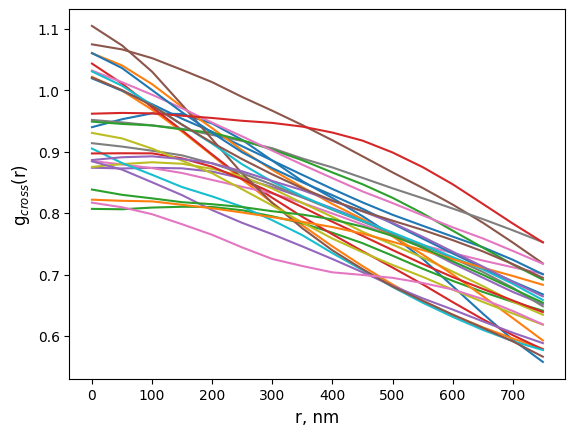

In [76]:
plt.figure()
for gr in lst_cross:
    plt.plot(bins, gr)
plt.xlabel("r, nm", fontsize=12)
plt.ylabel(r"g$_{cross}$(r)", fontsize=12)

Text(0, 0.5, 'g$_{auto}$(r)')

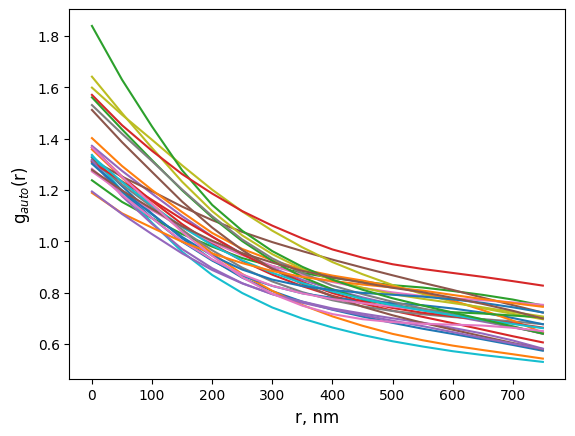

In [77]:
plt.figure()
for gr in lst_autoFUS:
    plt.plot(bins, gr)
plt.xlabel("r, nm", fontsize=12)
plt.ylabel(r"g$_{auto}$(r)", fontsize=12)